In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, accuracy_score, jaccard_similarity_score
from sklearn.metrics import confusion_matrix
import xgboost as xgb
# from sklearn.externals import joblib
from joblib import dump, load
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from evolutionary_search import EvolutionaryAlgorithmSearchCV
%matplotlib inline
print("Setting paths and datasets")
path_parent = os.path.dirname(os.getcwd())
data_dir = os.path.join(path_parent,'data')
model_dir = os.path.join(path_parent,'models')
processed_dir = os.path.join(data_dir,'processed')
df_anomaly = pd.read_csv(os.path.join(processed_dir,"anomaly_anotated.csv"))
df_audsome = pd.read_csv(os.path.join(processed_dir,"anomaly_anotated_audsome.csv"))

Setting paths and datasets


/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
print("Dataset chosen ...")
data = df_audsome
drop_col = ['t1','t2','t3','t4']
print("Remove unwanted columns ...")
print("Shape before drop: {}".format(data.shape))
data.drop(drop_col, axis=1, inplace=True)
print("Shape after drop: {}".format(data.shape))

# Nice print
nice_y = data['target']

# Uncomment for removing dummy
data.loc[data.target == "dummy", 'target'] = "0"

#Creating the dependent variable class
factor = pd.factorize(data['target'])
data.target = factor[0]
definitions = factor[1]
# print(data.target.head())
# print(definitions)

Dataset chosen ...
Remove unwanted columns ...
Shape before drop: (3900, 67)
Shape after drop: (3900, 63)


In [3]:
print("Splitting dataset into training and ground truth ...")
X = data.drop('target', axis=1)
y = data['target']

Splitting dataset into training and ground truth ...


Ploting class distribution ..


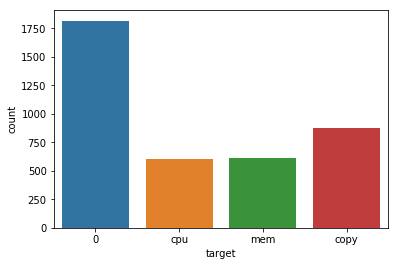

In [4]:
# Plot class distribution
print("Ploting class distribution ..")
sns.countplot(nice_y)

In [5]:
print("Scaling dataset")
scaler = StandardScaler()
# scaler = RobustScaler()
X = scaler.fit_transform(X)

Scaling dataset


In [11]:
# RandomForest
# prefix = 'RF_3'
# dnn = False
# paramgrid = {
#     "n_estimators": [10, 50, 100, 200, 300, 500],
#     "max_depth": [5, 10, 25, 50, None],
#     "max_features": [1, 5, 10, 20, 30, 50, 60, 'auto'],
#     "min_samples_split":[2, 5, 11],
#     "min_samples_leaf":[1, 5, 11],
#     "criterion": ['entropy', 'gini'],
#     "random_state": [42]
# }
# model = RandomForestClassifier()

# XGBoost
# prefix = 'xgb_4'
# dnn = False
# paramgrid = {
#     'n_estimators': [10, 50, 100, 200, 300],
#     'max_depth': [3, 4, 6],
#     'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
#     'subsample': [0.2, 0.5, 1],
#     'min_child_weight':[1, 2, 5, 6],
#     'gamma':[0, 0.1, 1],
#     'seed': [42],
#     'objective': ['multi:softmax'],  # error evaluation for multiclass training
#     # 'num_class': [len(definitions)],
# }
# #
# model = xgb.XGBClassifier()
# model.get_params().keys()
#
# DNN
prefix = 'dnn_3'
dnn = True # needed for special reporting features
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam, Adagrad, SGD
from tensorflow.keras.utils import plot_model

paramgrid = {
    "optimizer": ["adam", "adagrad", "sgd"],
    "learning_r": [0.01, 0.0001 , 0.003, 0.001],
    "patience" : [4],
    "batch_size": [32, 64, 128, 256],
    "epochs": [300],
    "kernel_init": ['he_uniform', 'he_normal'],
    "layer_1": [0, 50, 100],
    "layer_2": [0,  50, 100],
    "layer_3": [0,  50, 100],
    "layer_0": [0, 200, 100, 50],
    "drop": [0, 0.1, 0.2, 0.3, 0.4],
    "loss": ["categorical_crossentropy"],
    "activation_1": ['relu', 'elu', 'selu'],
    "out_activation":["sigmoid"]
}

y_oh = pd.get_dummies(y, prefix='target')

# Reverse one hot encoding
def reverse_oh(y_oh):
    decode = []
    for r in y_oh:
        # print(r)
        result = np.where(r == 1.)[0]
        # print(result)
        #check if network asigned more than one or non labels
        if len(result) > 1 or len(result) == 0:
            if len(result) > 1:
                result = np.array([result[0]])  # select first class
            elif len(result) == 0:
                result = np.array([0])

        decode.append(result[0])
    return decode


def dnn_aspide(optimizer='adam', #adam, adagrad, sgd
               learning_r = 0.01,
              patience=5,
              batch_size=32,
              epochs=1000,
              kernel_init='he_uniform',
              layer_1 = 20,
              layer_2 = 40,
              layer_3 = 40,
              layer_0 = 100,
              drop = 0.1,
              loss='categorical_crossentropy',
              activation_1 = 'relu', # elu, selu
              out_activation='sigmoid'):
    y_oh = pd.get_dummies(y, prefix='target')
    # print(np.asarray(X).shape[1], len(y_oh.nunique()))
    n_inputs, n_outputs = X.shape[1], len(y_oh.nunique())
    model = Sequential()
    # model.add(Conv1D(filters=32, kernel_size=2,activation=activation_1, input_shape=n_inputs, kernel_initializer=kernel_init))
    model.add(Dense(layer_0, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
    if drop:
        model.add(Dropout(drop))
    if layer_1:
        model.add(Dense(layer_1, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
        if drop:
            model.add(Dropout(drop))
    if layer_2:
        model.add(Dense(layer_2, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
        if drop:
            model.add(Dropout(drop))
    if layer_3:
        model.add(Dense(layer_2, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
        if drop:
            model.add(Dropout(drop))
    model.add(Dense(n_outputs, activation=out_activation))
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_r)
    if optimizer == 'adagrad':
        opt = Adagrad(learning_rate=learning_r)
    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_r)
    else:
        opt = Adam(learning_rate=0.01)
    model.compile(optimizer = opt, loss=loss, metrics=['accuracy', 'categorical_crossentropy', 'binary_crossentropy'])
    early_stopping = EarlyStopping(monitor="loss", patience = patience)# early stop patience
    history = model.fit(np.asarray(X), np.asarray(y_oh),
              batch_size=batch_size,
              epochs=epochs,
              callbacks = [early_stopping],
              verbose=0) #verbose set to 1 will show the training process
    # df_history = pd.DataFrame(h.history)
    # df_history
    return model

# model = dnn_aspide()
model = KerasClassifier(build_fn=dnn_aspide, verbose=0)

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

In [12]:
#Example of HPO methods https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms/blob/master/HPO_Classification.ipynb
# scorer = make_scorer(accuracy_score, )
scorer = make_scorer(jaccard_similarity_score)
# scorer = 'accuracy'
n_splits = 2 # default 4
if not dnn:
    cv_type = StratifiedKFold(n_splits=n_splits)
    nj = 8
else:
    # cv_type = KFold(n_splits=n_splits)
    cv_type = None
    nj = 1
cv = EvolutionaryAlgorithmSearchCV(estimator=model,
                                   params=paramgrid,
                                   scoring=scorer,
                                   cv=cv_type, # StratifiedKFold not supported for multilabel-indicator (oh encoding)
                                   verbose=4,
                                   population_size=20, # 40
                                   gene_mutation_prob=0.20,
                                   gene_crossover_prob=0.5,
                                   tournament_size=4,
                                   generations_number=30, #10
                                   n_jobs=nj) # for dnn n_jobs must be set to 1 rest is 8

/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [13]:
cv.fit(X, y)

TypeError: fit() got an unexpected keyword argument 'eval_metric'

In [88]:
# Remove bool values from dict
cv.cv_results_.pop('nan_test_score?')

print("Saving CV results")
file_name = "{}_hpo_best_cv.csv".format(prefix)
# with open(os.path.join(model_dir,file_name), 'w') as cvfile:
#     json.dump(cv.cv_results_, cvfile)
cv_test_scores = pd.DataFrame(cv.cv_results_)
cv_test_scores.to_csv(os.path.join(model_dir,file_name), index=False)
print("{} best params: {}".format(prefix, cv.best_params_))
param_name = "{}_hpo_best_param.json".format(prefix)
with open(os.path.join(model_dir,param_name), 'w') as cvfile:
    json.dump(cv.best_params_, cvfile)
print("{} best score: {}".format(prefix, cv.best_score_))
print("Saving best {} estimator".format(prefix))
if dnn:
    model_name = "{}_hpo_best.keras".format(prefix)
    cv.best_estimator_.model.save(os.path.join(model_dir, model_name))
else:
    model_name = "{}_hpo_best.joblib".format(prefix)
    dump(cv.best_estimator_, os.path.join(model_dir,model_name))

Saving CV results
dnn_2 best params: {'optimizer': 'sgd', 'learning_r': 0.01, 'patience': 4, 'batch_size': 32, 'epochs': 300, 'kernel_init': 'he_normal', 'layer_1': 0, 'layer_2': 50, 'layer_3': 100, 'layer_0': 50, 'drop': 0.3, 'loss': 'categorical_crossentropy', 'activation_1': 'elu', 'out_activation': 'sigmoid'}
dnn_2 best score: 0.9802083333333333
Saving best dnn_2 estimator


In [89]:
if not dnn:
    y_pred = cv.best_estimator_.predict(X)
    print("Accuracy score is: {}".format(accuracy_score(y, y_pred)))
    print("Ballanced accuracy score is: {}".format(balanced_accuracy_score(y, y_pred)))
    print("Jaccard score: {}".format(jaccard_similarity_score(y, y_pred)))
    print("Full classification report")
    print(classification_report(y, y_pred, target_names=definitions))
    report = classification_report(y, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    classification_rep_name = "{}_classification_rep_best.csv".format(prefix)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)

In [90]:
if not dnn:
    print("Confusion matrix")
    cf_matrix = confusion_matrix(y, y_pred)
    sns_cf = sns.heatmap(cf_matrix, annot=True, yticklabels=list(definitions), xticklabels=list(definitions))
    cf_fig = "{}_cf.png".format(prefix)
    sns_cf.figure.savefig(os.path.join(model_dir, cf_fig))


In [91]:
# Extract Feature importance
if not dnn:
    feat_importances = pd.Series(cv.best_estimator_.feature_importances_, index=list(data.drop('target', axis=1).columns))
    featureimp_name = "{}_hpo_best_featureimp.csv".format(prefix)
    feat_importances.to_csv(os.path.join(model_dir, featureimp_name), index=True)
    # print(feat_importances.head(10))
    sorted_feature = feat_importances.sort_values(ascending=True)
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.barh(range(X.shape[1]), sorted_feature,
           color="r", align="center")
    # If you want to define your own labels,
    # change indices to a list of labels on the following line.
    plt.yticks(range(X.shape[1]), sorted_feature.index)
    plt.ylim([-1, X.shape[1]])
    plt.show()


In [92]:
# Special case for DNN
if dnn:
    y_pred = cv.best_estimator_.predict(X)
    # print(y_pred)
    # print(y)
    # y_pred = y_pred.round()
    # y_pred = reverse_oh(y_pred)
    # print(y_pred)
    # # print(decode)
    print("Accuracy score is: {}".format(accuracy_score(y, y_pred)))
    print("Ballanced accuracy score is: {}".format(balanced_accuracy_score(y, y_pred)))
    print("Jaccard score: {}".format(jaccard_similarity_score(y, y_pred)))
    print("Full classification report")
    print(classification_report(y, y_pred, target_names=definitions))
    report = classification_report(y, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    classification_rep_name = "{}_classification_rep_best.csv".format(prefix)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)


Accuracy score is: 0.9847916666666666
Ballanced accuracy score is: 0.9830232215376874
Jaccard score: 0.9847916666666666
Full classification report
              precision    recall  f1-score   support

        copy       0.99      0.98      0.98       497
         mem       0.99      0.99      0.99      1458
           0       0.98      0.98      0.98      2365
         cpu       0.98      0.98      0.98       480

    accuracy                           0.98      4800
   macro avg       0.98      0.98      0.98      4800
weighted avg       0.98      0.98      0.98      4800



/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


Confusion matrix


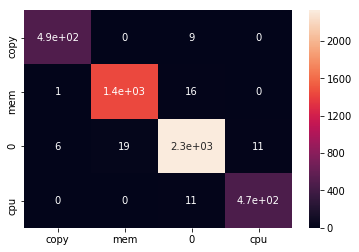

In [93]:
# Special CF for DNN
if dnn:
    print("Confusion matrix")
    cf_matrix = confusion_matrix(y, y_pred)
    sns_cf = sns.heatmap(cf_matrix, annot=True, yticklabels=list(definitions), xticklabels=list(definitions))
    cf_fig = "{}_cf.png".format(prefix)
    sns_cf.figure.savefig(os.path.join(model_dir, cf_fig))

In [94]:
if dnn:
    # DNN history export
    df_history = pd.DataFrame(cv.best_estimator_.model.history.history)
    history_name = "{}_history.csv".format(prefix)
    df_history.to_csv(os.path.join(model_dir,history_name), index=False)
df_history

,loss,accuracy,categorical_crossentropy,binary_crossentropy
0,0.122951,0.977708,0.122952,0.104187
1,0.119649,0.977708,0.119649,0.102784
2,0.124109,0.979375,0.124109,0.105827
3,0.124286,0.977500,0.124286,0.102397
4,0.125462,0.978542,0.125462,0.105858
...,...,...,...,...
295,0.086398,0.983333,0.086398,0.079046
296,0.084873,0.984583,0.084873,0.078958
297,0.086587,0.983542,0.086587,0.079537
298,0.086224,0.983958,0.086224,0.080009


In [95]:
if dnn:
    # Export DNN topology
    print("Saving topology")
    topology_name = "{}_topology.png".format(prefix)
    plot_model(cv.best_estimator_.model, to_file=os.path.join(model_dir, topology_name), show_shapes=True)


Saving topology
